  

# ⚽ Defensive Analysis Project – Out of Possession Behavior

  

This document provides an overview of the Python scripts used to analyze our team's **defensive behavior**, **structure**, and **vulnerabilities**, particularly when **out of possession**.

  

---

  

## 📂 File Overview

| File                                               | Description                                                        |
| -------------------------------------------------- | ------------------------------------------------------------------ |
| `01_initial_visual_test.py`                        | First experiment in visualizing data – used for sandboxing         |
| `02_defensive_turnover_zones.py`                   | Histogram of where we lost the ball across zones                   |
| `03_avg_defensive_positions_single_game.py`        | Average player positions during defense (one match)                |
| `04_rogue_defensive_shape.py`                      | *(Clarify purpose — appears to analyze irregular defensive shape)* |
| `05_avg_defensive_shape_clean_sheets.py`           | Defensive shape in matches with clean sheets                       |
| `06_avg_defensive_shape_conceded.py`               | Defensive shape in matches where we conceded                       |
| `07_compare_defensive_shapes_clean_vs_conceded.py` | Overlay comparison of average defensive shape (clean vs conceded)  |
| `08_scatter_defensive_actions.py`                  | Scatter plot of tackles, interceptions, clearances, duels          |
| `09_opponent_progress_single_game.py`              | Opponent pass progression in one match                             |
| `10_opponent_progress_multiple_games.py`           | Same as above but across multiple matches                          |
| `11_defensive_losses_histogram_line.py`            | Histogram & line chart of lost defensive actions                   |
| `12_defensive_wins_line_histogram.py`              | Line & histogram of successful defensive actions                   |
  

## Prerequisites
- Python 3.
- Libraries: pandas, matplotlib, psycopg2, sqlalchemy.
- Read-only access to the PostgreSQL database.

## Step 1: Load Tracking Data
We will fetch tracking data directly from the database.

In [ ]:
%pip install sqlalchemy matplotsoccer mplsoccer dotenv pandas -q

## Step 2 run things
### `01_turnover_heatmap.py`


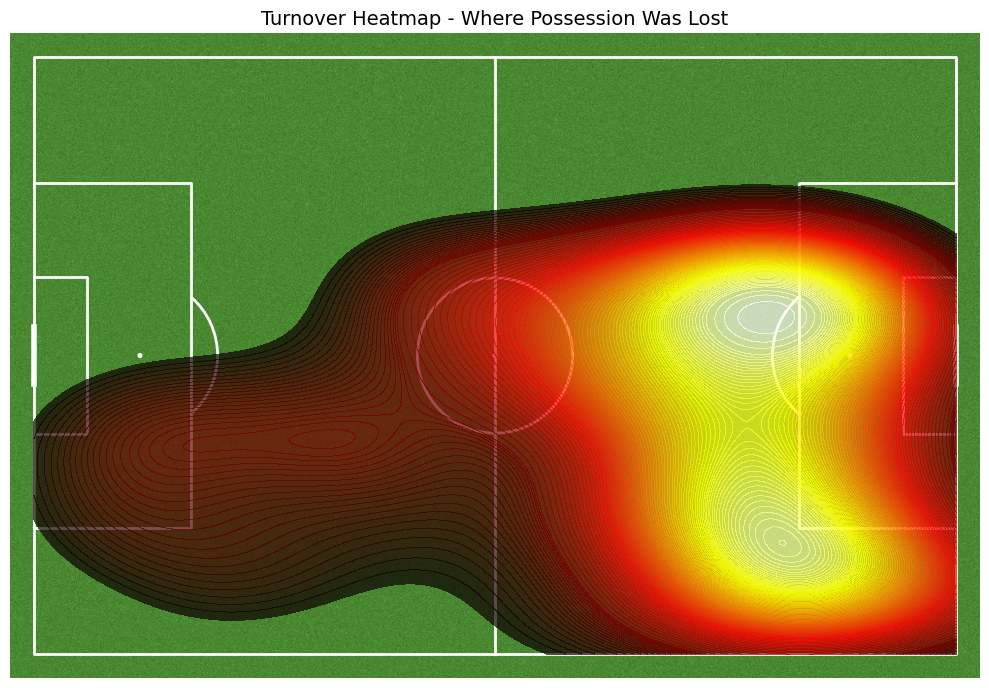

In [5]:
# turnover_heatmap.py
import pandas as pd
from db_connection import get_connection
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# Connect to DB and run the possession query
conn = get_connection()

query = """
WITH action_changes AS (
    SELECT
        a.*,
        LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
        LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
    FROM
        spadl_actions a
    WHERE
        a.game_id = '5uts2s7fl98clqz8uymaazehg'
),

possession_markers AS (
    SELECT
        *,
        CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
    FROM
        action_changes
),

possession_sequences AS (
    SELECT
        *,
        SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_group
    FROM
        possession_markers
),

possession_stats AS (
    SELECT
        possession_group,
        team_id,
        COUNT(*) AS action_count,
        MAX(id) AS last_action_id
    FROM
        possession_sequences
    GROUP BY
        possession_group, team_id
)

SELECT
    a.id AS action_id,
    a.game_id,
    a.period_id,
    a.seconds AS time_seconds,
    p.player_name,
    t.team_name AS team_losing_possession,
    nt.team_name AS team_gaining_possession,
    a.action_type AS type_name,
    a.result AS result_name,
    ps.action_count AS consecutive_team_actions,
    a.start_x,
    a.start_y,
    a.end_x,
    a.end_y,
    a.id AS original_event_id,
    a.team_id
FROM
    possession_sequences a
JOIN
    possession_stats ps ON a.possession_group = ps.possession_group 
                        AND a.team_id = ps.team_id
                        AND a.id = ps.last_action_id  
JOIN
    players p ON a.player_id = p.player_id
JOIN
    teams t ON a.team_id = t.team_id
LEFT JOIN
    teams nt ON a.next_team_id = nt.team_id
WHERE
    ps.action_count >= 3  
    AND a.team_id != a.next_team_id  
    AND a.next_team_id IS NOT NULL  
ORDER BY
    a.period_id,
    a.seconds,
    a.id;
"""

# Load the possession-ending actions
possession_df = pd.read_sql_query(query, conn)

# Close connection
conn.close()

# 🔥 Plot turnover heatmap for your team
your_team_id = possession_df['team_id'].unique()[0]  # You can adjust this

team_turnovers = possession_df[possession_df['team_id'] == your_team_id]

pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta',
              pitch_length=105, pitch_width=68)
fig, ax = pitch.draw(figsize=(10, 7))

pitch.kdeplot(
    x=team_turnovers['start_x'],
    y=team_turnovers['start_y'],
    ax=ax,
    cmap='hot',
    fill=True,
    levels=100,
    alpha=0.7
)

ax.set_title('Turnover Heatmap - Where Possession Was Lost', fontsize=14)
plt.show()


### `02_defensive_turnover_zones.py`

C:\Users\adam\AppData\Local\Temp\ipykernel_31668\744567484.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_turnovers['third'] = team_turnovers['start_x'].apply(lambda x: classify_zone(x, 0))
C:\Users\adam\AppData\Local\Temp\ipykernel_31668\744567484.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_turnovers['side'] = team_turnovers['start_y'].apply(classify_side)
C:\Users\adam\AppData\Local\Temp\ipykernel_31668\744567484.py:114: SettingWithCopyWarning: 
A value is trying to be set on a 

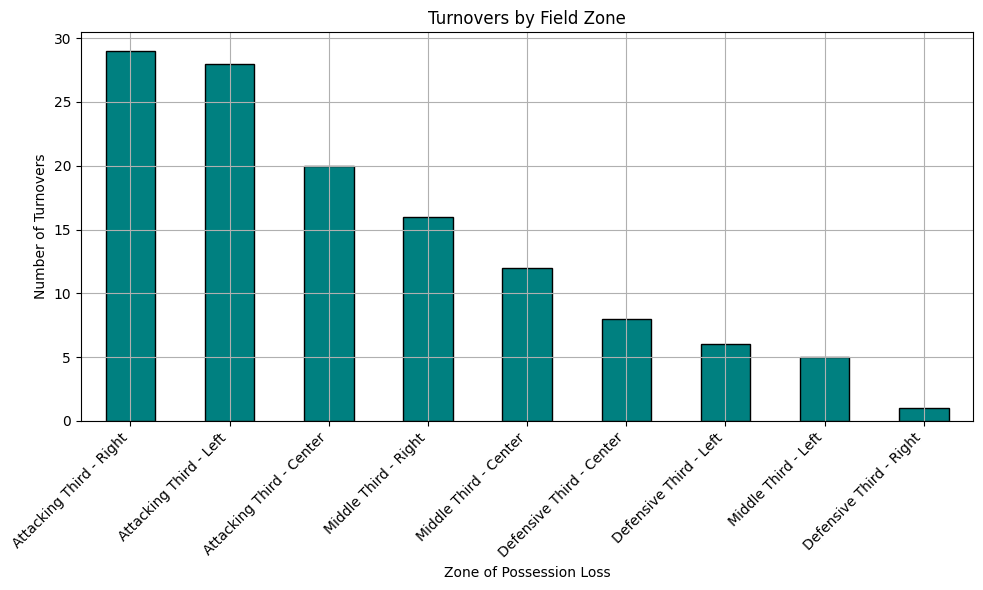

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from db_connection import get_connection

# Connect and fetch turnover data again
conn = get_connection()
query = """
WITH action_changes AS (
    SELECT
        a.*,
        LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
        LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
    FROM
        spadl_actions a
    WHERE
        a.game_id = '5uts2s7fl98clqz8uymaazehg'
),

possession_markers AS (
    SELECT
        *,
        CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
    FROM
        action_changes
),

possession_sequences AS (
    SELECT
        *,
        SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_group
    FROM
        possession_markers
),

possession_stats AS (
    SELECT
        possession_group,
        team_id,
        COUNT(*) AS action_count,
        MAX(id) AS last_action_id
    FROM
        possession_sequences
    GROUP BY
        possession_group, team_id
)

SELECT
    a.id AS action_id,
    a.game_id,
    a.period_id,
    a.seconds AS time_seconds,
    p.player_name,
    t.team_name AS team_losing_possession,
    nt.team_name AS team_gaining_possession,
    a.action_type AS type_name,
    a.result AS result_name,
    ps.action_count AS consecutive_team_actions,
    a.start_x,
    a.start_y,
    a.end_x,
    a.end_y,
    a.id AS original_event_id,
    a.team_id
FROM
    possession_sequences a
JOIN
    possession_stats ps ON a.possession_group = ps.possession_group 
                        AND a.team_id = ps.team_id
                        AND a.id = ps.last_action_id  
JOIN
    players p ON a.player_id = p.player_id
JOIN
    teams t ON a.team_id = t.team_id
LEFT JOIN
    teams nt ON a.next_team_id = nt.team_id
WHERE
    ps.action_count >= 3  
    AND a.team_id != a.next_team_id  
    AND a.next_team_id IS NOT NULL  
ORDER BY
    a.period_id,
    a.seconds,
    a.id;
"""

possession_df = pd.read_sql_query(query, conn)
conn.close()

# Filter your team
your_team_id = possession_df['team_id'].unique()[0]
team_turnovers = possession_df[possession_df['team_id'] == your_team_id]

# Define zones (you can tweak boundaries)
def classify_zone(x, y):
    if x < 35:
        return 'Defensive Third'
    elif x < 70:
        return 'Middle Third'
    else:
        return 'Attacking Third'

def classify_side(y):
    if y < 22.6:
        return 'Left'
    elif y < 45.3:
        return 'Center'
    else:
        return 'Right'

team_turnovers['third'] = team_turnovers['start_x'].apply(lambda x: classify_zone(x, 0))
team_turnovers['side'] = team_turnovers['start_y'].apply(classify_side)

# Combine zones
team_turnovers['zone'] = team_turnovers['third'] + ' - ' + team_turnovers['side']

# Count zones
zone_counts = team_turnovers['zone'].value_counts().sort_values(ascending=False)

# Plot bar chart
plt.figure(figsize=(10, 6))
zone_counts.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Turnovers by Field Zone')
plt.xlabel('Zone of Possession Loss')
plt.ylabel('Number of Turnovers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()


### `03_avg_defensive_positions_single_game.py`

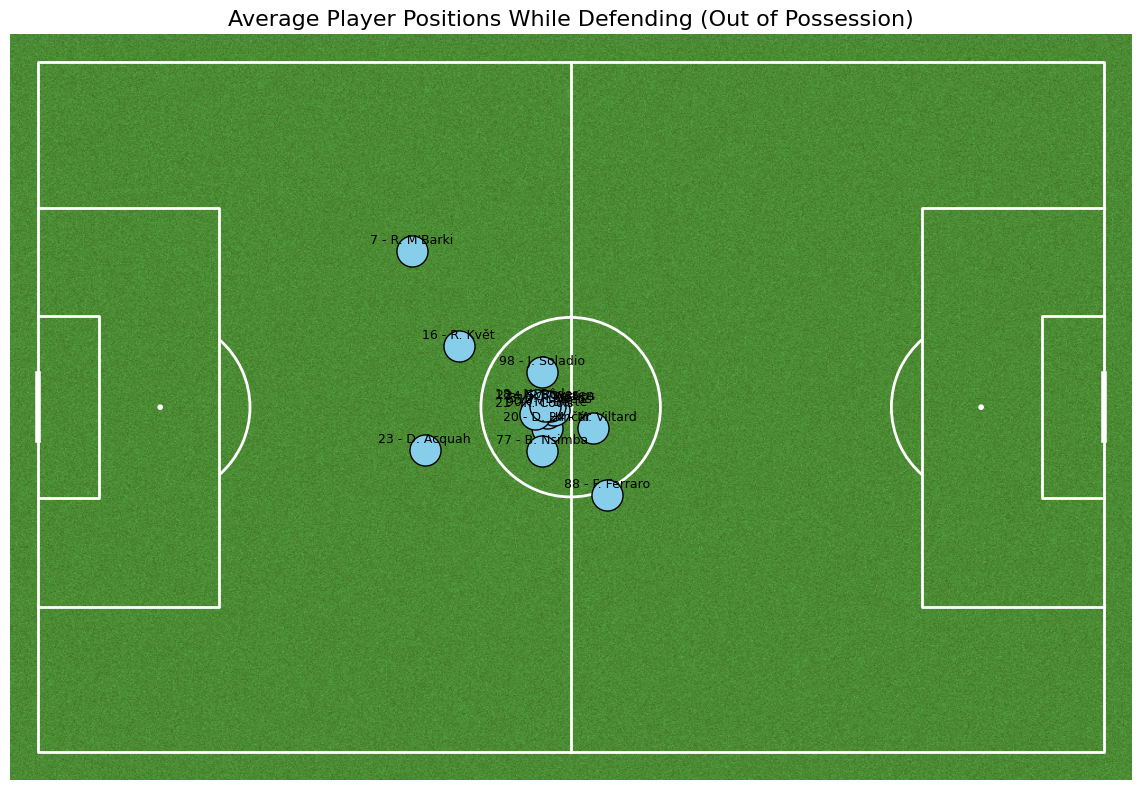

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from db_connection import get_connection

# Step 1: Get player tracking data
conn = get_connection()
query_tracking = """
SELECT pt.frame_id, pt.timestamp, pt.player_id, pt.x, pt.y, p.jersey_number, p.player_name, p.team_id
FROM player_tracking pt
JOIN players p ON pt.player_id = p.player_id
WHERE pt.game_id = '5uts2s7fl98clqz8uymaazehg'
"""
tracking_df = pd.read_sql_query(query_tracking, conn)

# 🔧 Convert 'timestamp' to total seconds
tracking_df['seconds'] = pd.to_timedelta(tracking_df['timestamp']).dt.total_seconds().round()

# Step 2: Get possession info to find defending frames
query_possession = """
SELECT 
    a.id, 
    a.period_id, 
    a.seconds,
    a.team_id AS possessing_team,
    LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id
FROM spadl_actions a
WHERE a.game_id = '5uts2s7fl98clqz8uymaazehg'
"""
poss_df = pd.read_sql_query(query_possession, conn)
conn.close()

# Step 3: Identify your team
your_team_id = tracking_df['team_id'].unique()[0]

# Step 4: Get timestamps (seconds) when opponent has possession
defending_times = poss_df[poss_df['possessing_team'] != your_team_id]['seconds'].unique()

# Step 5: Filter tracking data to those defending moments
defending_tracking = tracking_df[tracking_df['seconds'].isin(defending_times.round())]

# Step 6: Keep only your team’s players
defending_tracking = defending_tracking[defending_tracking['team_id'] == your_team_id]

# Step 7: Compute average positions
avg_positions = defending_tracking.groupby(['player_id', 'player_name', 'jersey_number']).agg({
    'x': 'mean',
    'y': 'mean'
}).reset_index()

# Step 8: Plot
pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta',
              pitch_length=105, pitch_width=68)
fig, ax = pitch.draw(figsize=(12, 8))

pitch.scatter(
    avg_positions['x'],
    avg_positions['y'],
    ax=ax,
    s=500,
    color='skyblue',
    edgecolor='black'
)

# Add player numbers/names
for _, row in avg_positions.iterrows():
    ax.text(row['x'], row['y'] + 1, f"{row['jersey_number']} - {row['player_name']}", ha='center', fontsize=9)

    

ax.set_title('Average Player Positions While Defending (Out of Possession)', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
### `04_rogue_defensive_shape.py`

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from db_connection import get_connection

# === CONFIGURATION ===
game_id = '5ugfsw7je1y0lay7xdqe3pces'
your_team_id = '1oyb7oym5nwzny8vxf03szd2h'

# === HELPER FUNCTION ===
def hms_to_seconds(hms):
    try:
        h, m, s = map(int, hms.split(':'))
        return h * 3600 + m * 60 + s
    except:
        return None

# === 1. LOAD TRACKING DATA ===
conn = get_connection()
query_tracking = f"""
SELECT pt.frame_id, pt.timestamp, pt.player_id, pt.x, pt.y, 
       p.jersey_number, p.player_name, p.team_id
FROM player_tracking pt
JOIN players p ON pt.player_id = p.player_id
WHERE pt.game_id = '{game_id}'
"""
tracking_df = pd.read_sql_query(query_tracking, conn)
tracking_df = tracking_df[tracking_df['player_name'] != 'Ball']
tracking_df['seconds'] = tracking_df['timestamp'].apply(hms_to_seconds)
tracking_df.dropna(subset=['seconds'], inplace=True)

# === 2. LOAD POSSESSION DATA ===
query_possession = f"""
SELECT a.seconds, a.team_id AS possessing_team
FROM spadl_actions a
WHERE a.game_id = '{game_id}'
"""
poss_df = pd.read_sql_query(query_possession, conn)
conn.close()

# === 3. IDENTIFY DEFENSIVE SECONDS ===
defending_secs = poss_df[poss_df['possessing_team'] != your_team_id]['seconds'].unique()

# Expand each second to ±1 for matching
expanded_secs = {int(sec + offset) for sec in defending_secs for offset in [-1, 0, 1]}

# === 4. FILTER DEFENSIVE TRACKING FRAMES ===
defending_tracking = tracking_df[
    (tracking_df['team_id'] == your_team_id) &
    (tracking_df['seconds'].round().astype(int).isin(expanded_secs))
]

# === 5. CALCULATE AVERAGE POSITIONS ===
avg_positions = defending_tracking.groupby(
    ['player_id', 'player_name', 'jersey_number']
)[['x', 'y']].mean().reset_index()

# === 6. PLOT ===
pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta',
              pitch_length=105, pitch_width=68)
fig, ax = pitch.draw(figsize=(12, 8))

pitch.scatter(avg_positions['x'], avg_positions['y'], ax=ax, s=500,
              color='skyblue', edgecolor='black')

for _, row in avg_positions.iterrows():
    ax.text(row['x'], row['y'] + 1, f"{row['jersey_number']} - {row['player_name']}",
            ha='center', fontsize=9)

ax.set_title('Average Player Positions While Defending (Out of Possession)', fontsize=16)
plt.tight_layout()
plt.show()


### `05_avg_defensive_shape_clean_sheets.py`

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from db_connection import get_connection

# === CONFIG ===
your_team_id = '4dtif7outbuivua8umbwegoo5'

# Clean-sheet matches (from previous output)
clean_sheet_match_ids = [
    '5ow2wa823rjft38oh48b4ror8',
    '6j7t38109kev3yht9gfv7oopg',
    '6laud87o2272y9txxwvok2n84',
    '756u46khy7yhi4q7hljt6i8lw',
    '76pcoyeqglfmatz35cpaml0yc'
]

# === FUNCTIONS ===

def hms_to_seconds(hms_string):
    try:
        h, m, s = map(int, hms_string.split(':'))
        return h * 3600 + m * 60 + s
    except:
        return None

def get_defending_tracking_for_match(game_id, conn):
    # Get tracking data
    query_tracking = f"""
    SELECT pt.frame_id, pt.timestamp, pt.player_id, pt.x, pt.y, p.jersey_number, p.player_name, p.team_id
    FROM player_tracking pt
    JOIN players p ON pt.player_id = p.player_id
    WHERE pt.game_id = '{game_id}'
    """
    tracking_df = pd.read_sql_query(query_tracking, conn)
    tracking_df = tracking_df[tracking_df['player_name'] != 'Ball']
    tracking_df['seconds'] = tracking_df['timestamp'].apply(hms_to_seconds)
    tracking_df = tracking_df.dropna(subset=['seconds'])

    # Get possession info
    query_possession = f"""
    SELECT a.seconds, a.team_id AS possessing_team
    FROM spadl_actions a
    WHERE a.game_id = '{game_id}'
    """
    poss_df = pd.read_sql_query(query_possession, conn)
    defending_times = poss_df[poss_df['possessing_team'] != your_team_id]['seconds'].unique()

    # Expand defending seconds ±1s
    expanded_defending_seconds = set()
    for sec in defending_times:
        expanded_defending_seconds.update([sec - 1, sec, sec + 1])

    defending_tracking = tracking_df[
        tracking_df['seconds'].round().astype(int).isin(expanded_defending_seconds)
    ]

    # Keep only your players
    defending_tracking = defending_tracking[defending_tracking['team_id'] == your_team_id]

    return defending_tracking

# === PROCESS ALL MATCHES ===
conn = get_connection()

all_defending_tracking = pd.DataFrame()

for match_id in clean_sheet_match_ids:
    print(f"Processing match: {match_id}")
    df = get_defending_tracking_for_match(match_id, conn)
    all_defending_tracking = pd.concat([all_defending_tracking, df], ignore_index=True)

conn.close()

# === COMPUTE AVERAGE POSITIONS ===
avg_positions = all_defending_tracking.groupby(
    ['player_id', 'player_name', 'jersey_number']
).agg({'x': 'mean', 'y': 'mean'}).reset_index()

# === PLOT ===
pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta',
              pitch_length=105, pitch_width=68)
fig, ax = pitch.draw(figsize=(12, 8))

pitch.scatter(
    avg_positions['x'], avg_positions['y'],
    ax=ax, s=500, color='skyblue', edgecolor='black'
)

for _, row in avg_positions.iterrows():
    ax.text(row['x'], row['y'] + 1, f"{row['jersey_number']} - {row['player_name']}", 
            ha='center', fontsize=9)

ax.set_title("Average Defensive Shape (Clean Sheet Matches)", fontsize=16)
plt.tight_layout()
plt.show()


### `06_avg_defensive_shape_conceded.py`

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from db_connection import get_connection

# === CONFIG ===
your_team_id = '4dtif7outbuivua8umbwegoo5'

# === Step 1: Get matches where your team conceded a goal ===
conn = get_connection()
query = f"""
SELECT match_id, home_team_id, away_team_id, home_score, away_score
FROM matches
WHERE (
    (home_team_id = '{your_team_id}' AND away_score > 0)
    OR
    (away_team_id = '{your_team_id}' AND home_score > 0)
)
"""
lost_goal_matches = pd.read_sql_query(query, conn)
match_ids = lost_goal_matches['match_id'].tolist()
print("Matches where we conceded goals:", match_ids)

# === FUNCTIONS ===

def hms_to_seconds(hms_string):
    try:
        h, m, s = map(int, hms_string.split(':'))
        return h * 3600 + m * 60 + s
    except:
        return None

def get_defending_tracking_for_match(game_id, conn):
    # Get tracking data
    query_tracking = f"""
    SELECT pt.frame_id, pt.timestamp, pt.player_id, pt.x, pt.y, p.jersey_number, p.player_name, p.team_id
    FROM player_tracking pt
    JOIN players p ON pt.player_id = p.player_id
    WHERE pt.game_id = '{game_id}'
    """
    tracking_df = pd.read_sql_query(query_tracking, conn)
    tracking_df = tracking_df[tracking_df['player_name'] != 'Ball']
    tracking_df['seconds'] = tracking_df['timestamp'].apply(hms_to_seconds)
    tracking_df = tracking_df.dropna(subset=['seconds'])

    # Get possession info
    query_possession = f"""
    SELECT a.seconds, a.team_id AS possessing_team
    FROM spadl_actions a
    WHERE a.game_id = '{game_id}'
    """
    poss_df = pd.read_sql_query(query_possession, conn)
    defending_times = poss_df[poss_df['possessing_team'] != your_team_id]['seconds'].unique()

    # Expand defending seconds ±1s
    expanded_defending_seconds = set()
    for sec in defending_times:
        expanded_defending_seconds.update([sec - 1, sec, sec + 1])

    defending_tracking = tracking_df[
        tracking_df['seconds'].round().astype(int).isin(expanded_defending_seconds)
    ]

    # Keep only your players
    defending_tracking = defending_tracking[defending_tracking['team_id'] == your_team_id]

    return defending_tracking

# === PROCESS ALL MATCHES ===
all_defending_tracking = pd.DataFrame()

for match_id in match_ids:
    print(f"Processing match: {match_id}")
    df = get_defending_tracking_for_match(match_id, conn)
    all_defending_tracking = pd.concat([all_defending_tracking, df], ignore_index=True)

conn.close()

# === COMPUTE AVERAGE POSITIONS ===
avg_positions = all_defending_tracking.groupby(
    ['player_id', 'player_name', 'jersey_number']
).agg({'x': 'mean', 'y': 'mean'}).reset_index()

# === PLOT ===
pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta',
              pitch_length=105, pitch_width=68)
fig, ax = pitch.draw(figsize=(12, 8))

pitch.scatter(
    avg_positions['x'], avg_positions['y'],
    ax=ax, s=500, color='red', edgecolor='black'
)

for _, row in avg_positions.iterrows():
    ax.text(row['x'], row['y'] + 1, f"{row['jersey_number']} - {row['player_name']}", 
            ha='center', fontsize=9)

ax.set_title("Average Defensive Shape (When We Conceded Goals)", fontsize=16)
plt.tight_layout()
plt.show()


### `07_compare_defensive_shapes_clean_vs_conceded.py`

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from db_connection import get_connection

# === CONFIG ===
your_team_id = '4dtif7outbuivua8umbwegoo5'

# Define match lists
clean_sheet_match_ids = [
    '5ow2wa823rjft38oh48b4ror8',
    '6j7t38109kev3yht9gfv7oopg',
    '6laud87o2272y9txxwvok2n84',
    '756u46khy7yhi4q7hljt6i8lw',
    '76pcoyeqglfmatz35cpaml0yc'
]

# Get matches where team conceded
def get_conceded_match_ids(team_id):
    conn = get_connection()
    query = f"""
    SELECT match_id FROM matches
    WHERE (
        (home_team_id = '{team_id}' AND away_score > 0)
        OR
        (away_team_id = '{team_id}' AND home_score > 0)
    )
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df['match_id'].tolist()

conceded_match_ids = get_conceded_match_ids(your_team_id)

# === UTILS ===
def hms_to_seconds(hms_string):
    try:
        h, m, s = map(int, hms_string.split(':'))
        return h * 3600 + m * 60 + s
    except:
        return None

def get_defensive_positions(match_ids, your_team_id):
    conn = get_connection()
    all_tracking = pd.DataFrame()

    for match_id in match_ids:
        # Tracking data
        query_tracking = f"""
        SELECT pt.frame_id, pt.timestamp, pt.player_id, pt.x, pt.y, 
               p.jersey_number, p.player_name, p.team_id
        FROM player_tracking pt
        JOIN players p ON pt.player_id = p.player_id
        WHERE pt.game_id = '{match_id}'
        """
        tracking_df = pd.read_sql_query(query_tracking, conn)
        tracking_df = tracking_df[tracking_df['player_name'] != 'Ball']
        tracking_df['seconds'] = tracking_df['timestamp'].apply(hms_to_seconds)
        tracking_df = tracking_df.dropna(subset=['seconds'])

        # Possession info
        query_possession = f"""
        SELECT seconds, team_id AS possessing_team
        FROM spadl_actions
        WHERE game_id = '{match_id}'
        """
        poss_df = pd.read_sql_query(query_possession, conn)
        defending_times = poss_df[poss_df['possessing_team'] != your_team_id]['seconds'].unique()

        # Match tracking seconds to possession time ±1s
        expanded_def_times = set()
        for t in defending_times:
            expanded_def_times.update([t - 1, t, t + 1])

        match_tracking = tracking_df[
            tracking_df['seconds'].round().astype(int).isin(expanded_def_times)
        ]

        match_tracking = match_tracking[match_tracking['team_id'] == your_team_id]
        all_tracking = pd.concat([all_tracking, match_tracking], ignore_index=True)

    conn.close()
    return all_tracking

# === Get both shapes ===
print("Processing clean-sheet matches...")
clean_df = get_defensive_positions(clean_sheet_match_ids, your_team_id)

print("Processing conceded-goal matches...")
conceded_df = get_defensive_positions(conceded_match_ids, your_team_id)

# === Averages ===
avg_clean = clean_df.groupby(['player_id', 'player_name', 'jersey_number']).agg({'x': 'mean', 'y': 'mean'}).reset_index()
avg_conceded = conceded_df.groupby(['player_id', 'player_name', 'jersey_number']).agg({'x': 'mean', 'y': 'mean'}).reset_index()

# === Plot ===
pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta', pitch_length=105, pitch_width=68)
fig, ax = pitch.draw(figsize=(12, 8))

# Clean-sheet in blue
pitch.scatter(avg_clean['x'], avg_clean['y'], ax=ax, s=500, color='skyblue', edgecolor='black', label='Clean Sheet')

# Conceded goals in red
pitch.scatter(avg_conceded['x'], avg_conceded['y'], ax=ax, s=500, color='red', edgecolor='black', alpha=0.6, label='Conceded')

# Annotate players from clean-sheet
for _, row in avg_clean.iterrows():
    ax.text(row['x'], row['y'] + 1, f"{row['jersey_number']}", ha='center', fontsize=9, color='black')

ax.set_title("Average Defensive Shape – Clean Sheet (Blue) vs Conceded (Red)", fontsize=16)
ax.legend(loc='upper center')
plt.tight_layout()
plt.show()


### `08_scatter_defensive_actions.py`

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from db_connection import get_connection

# === CONFIG ===
your_team_id = '4dtif7outbuivua8umbwegoo5'
game_id = '5uts2s7fl98clqz8uymaazehg'

# Map action_type IDs to names
action_names = {
    '1': 'Tackle',
    '17': 'Interception',
    '18': 'Clearance',
    '14': 'Duel'
}
defensive_ids = list(action_names.keys())

# Connect
conn = get_connection()





ids_for_sql = ",".join(f"'{i}'" for i in defensive_ids)

# === Step 1: Get defensive actions by your team ===
query = f"""
SELECT 
    s.action_type, s.result,
    s.start_x, s.start_y, s.team_id, s.seconds,
    p.player_name, t.team_name
FROM spadl_actions s
JOIN players p ON s.player_id = p.player_id
JOIN teams t ON s.team_id = t.team_id
WHERE s.game_id = '{game_id}' 
  AND s.team_id = '{your_team_id}'
  AND s.action_type IN ({ids_for_sql})
"""
actions_df = pd.read_sql_query(query, conn)

# === Step 2: Get opponent possession seconds ===
query_poss = f"""
SELECT seconds, team_id as possessing_team
FROM spadl_actions
WHERE game_id = '{game_id}'
"""
poss_df = pd.read_sql_query(query_poss, conn)
conn.close()

# === Step 3: Filter to moments when we are out of possession ===
oppo_poss_secs = poss_df[poss_df['possessing_team'] != your_team_id]['seconds'].unique()
actions_df = actions_df[actions_df['seconds'].round().isin(pd.Series(oppo_poss_secs).round())]

# Map action_type numbers to readable labels
actions_df['action_label'] = actions_df['action_type'].map(action_names)

# === Step 4: Plot ===
pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta', pitch_length=105, pitch_width=68)
fig, ax = pitch.draw(figsize=(12, 8))

for label, group in actions_df.groupby('action_label'):
    pitch.scatter(
        group['start_x'], group['start_y'],
        ax=ax, s=120, label=label,
        alpha=0.7, edgecolor='black'
    )

ax.set_title("Defensive Actions Map – Out of Possession", fontsize=16)
ax.legend()
plt.tight_layout()
plt.show()


### `09_opponent_progress_single_game.py`

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from db_connection import get_connection

# CONFIG
your_team_id = '1oyb7oym5nwzny8vxf03szd2h'
game_id = '6rulhyb9xa5yczi1jntilsr9w'

conn = get_connection()

# === Step 1: Load all actions ===
query = f"""
SELECT s.action_type, s.start_x, s.start_y, s.end_x, s.end_y,
       s.team_id, s.seconds, s.result,
       p.player_name, t.team_name
FROM spadl_actions s
JOIN players p ON s.player_id = p.player_id
JOIN teams t ON s.team_id = t.team_id
WHERE s.game_id = '{game_id}'
"""
df = pd.read_sql_query(query, conn)
conn.close()

# === Step 2: Get opponent team ID
opponent_team_id = df[df['team_id'] != your_team_id]['team_id'].iloc[0]

# === Step 3: All opponent passes into your half
passes_into_our_half = df[
    (df['team_id'] == opponent_team_id) &
    (df['action_type'] == '10') &  # 10 = pass
    (df['end_x'].astype(float) > 52.5)  # assuming you defend left to right
].copy()

# Optional: calculate pass length to remove short/sideways passes
passes_into_our_half['pass_length'] = ((passes_into_our_half['end_x'] - passes_into_our_half['start_x'])**2 +
                                       (passes_into_our_half['end_y'] - passes_into_our_half['start_y'])**2) ** 0.5
passes_into_our_half = passes_into_our_half[passes_into_our_half['pass_length'] > 5]

# === Step 4: Classify where the pass ends (zones)
def classify_zone(x):
    if x < 35:
        return "Opponent Half"
    elif x < 70:
        return "Middle Third"
    else:
        return "Our Defensive Third"

passes_into_our_half['target_zone'] = passes_into_our_half['end_x'].apply(classify_zone)

# === Step 5: Count per zone
zone_counts = passes_into_our_half['target_zone'].value_counts().reindex(
    ['Opponent Half', 'Middle Third', 'Our Defensive Third'], fill_value=0
)

# === Step 6: Debug print
print("Opponent passes into our half found:", len(passes_into_our_half))
print(passes_into_our_half[['start_x', 'end_x', 'target_zone']].head())

# === Step 7: Plot
zone_counts.plot(kind='bar', color='orangered', edgecolor='black')
plt.title("Opponent Pass Targets Into Our Half")
plt.ylabel("Number of Passes")
plt.xlabel("Zone Where Pass Ended")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### `10_opponent_progress_multiple_games.py`

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from db_connection import get_connection

# === CONFIG ===
your_team_id = '1oyb7oym5nwzny8vxf03szd2h'
lost_game_ids = [
    '6aaebu7uj50ewu3irl3qmjg2c',
    '5ugfsw7je1y0lay7xdqe3pces',
    '5wofhz4hm81f0lk0ay8sumfis',
    '78nndczlbj2214zhtbfahs2s4',
    '6foamr1y4x3t549lo89xczuok',
    '6gfytd52ib44k8sm0pc8lohzo',
    '6uc41ha2woe8uz2y69t44j5ec',
    '5oc8drrbruovbuiriyhdyiyok'
]

conn = get_connection()

# === Prepare storage
all_zone_counts = {}

# === Loop through each match
for game_id in lost_game_ids:
    query = f"""
    SELECT s.action_type, s.start_x, s.start_y, s.end_x, s.end_y,
           s.team_id, s.seconds, s.result,
           p.player_name, t.team_name
    FROM spadl_actions s
    JOIN players p ON s.player_id = p.player_id
    JOIN teams t ON s.team_id = t.team_id
    WHERE s.game_id = '{game_id}'
    """
    df = pd.read_sql_query(query, conn)

    # Opponent team
    opponent_team_id = df[df['team_id'] != your_team_id]['team_id'].iloc[0]

    # Filter all opponent passes ending in our half
    passes = df[
        (df['team_id'] == opponent_team_id) &
        (df['action_type'] == '10') &  # Pass
        (df['end_x'].astype(float) > 52.5)  # our half (left-to-right assumed)
    ].copy()

    # Optional: keep only meaningful passes
    passes['pass_length'] = ((passes['end_x'] - passes['start_x'])**2 + 
                             (passes['end_y'] - passes['start_y'])**2) ** 0.5
    passes = passes[passes['pass_length'] > 5]

    # Classify by zone
    def classify_zone(x):
        if x < 35:
            return "Opponent Half"
        elif x < 70:
            return "Middle Third"
        else:
            return "Our Defensive Third"

    passes['target_zone'] = passes['end_x'].apply(classify_zone)
    zone_counts = passes['target_zone'].value_counts().reindex(
        ['Opponent Half', 'Middle Third', 'Our Defensive Third'], fill_value=0
    )

    all_zone_counts[game_id] = zone_counts

conn.close()

# === Create dataframe for plotting
zone_df = pd.DataFrame(all_zone_counts).T  # rows = games
zone_df.index.name = "Game ID"

# === Plot grouped bar chart
zone_df.plot(kind='bar', figsize=(10, 6), edgecolor='black')
plt.title("Opponent Pass Target Zones – Matches We Lost")
plt.ylabel("Number of Passes")
plt.xlabel("Match ID")
plt.xticks(rotation=45)
plt.legend(title="Zone")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### `11_defensive_losses_histogram_line.py`

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from db_connection import get_connection

# CONFIG
your_team_id = '1oyb7oym5nwzny8vxf03szd2h' 
game_id = '6aaebu7uj50ewu3irl3qmjg2c' # loss 2-4
# Defensive action types (as strings in your DB)
defensive_types = {
    '1': 'Tackle',
    '14': 'Duel',
    '17': 'Interception',
    '18': 'Clearance'
}

# Connect and load data
conn = get_connection()
query = f"""
SELECT action_type, seconds, team_id
FROM spadl_actions
WHERE game_id = '{game_id}' AND team_id = '{your_team_id}'
"""
df = pd.read_sql_query(query, conn)
conn.close()

# Filter only defensive actions
df = df[df['action_type'].isin(defensive_types.keys())]
df['action_label'] = df['action_type'].map(defensive_types)

# === 3️⃣ Histogram of Defensive Action Types ===
type_counts = df['action_label'].value_counts().reindex(defensive_types.values(), fill_value=0)

plt.figure(figsize=(8, 5))
type_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title("Count of Defensive Actions by Type")
plt.ylabel("Number of Actions")
plt.xlabel("Action Type")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 4️⃣ Line Graph: Defensive Actions Over Time (Minute bins) ===
df['minute'] = df['seconds'] // 60
actions_per_min = df.groupby('minute').size()

plt.figure(figsize=(10, 4))
actions_per_min.plot(kind='line', marker='o', color='darkgreen')
plt.title("Defensive Actions Per Minute")
plt.xlabel("Minute")
plt.ylabel("Number of Actions")
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### `12_defensive_wins_line_histogram.py`

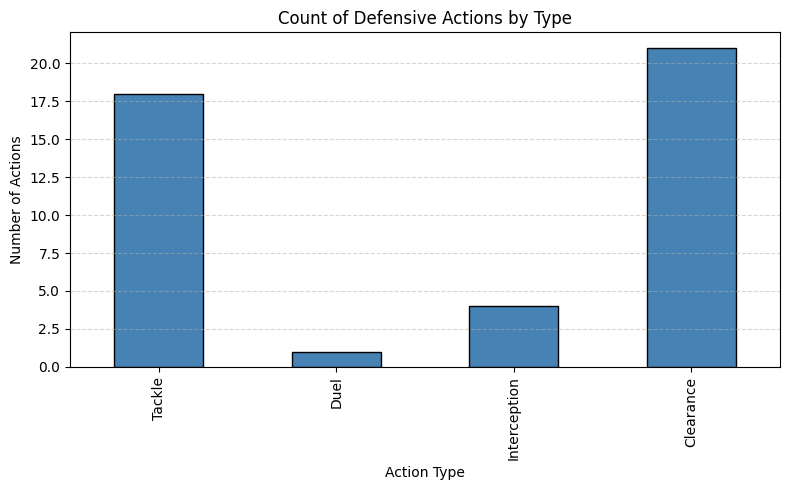

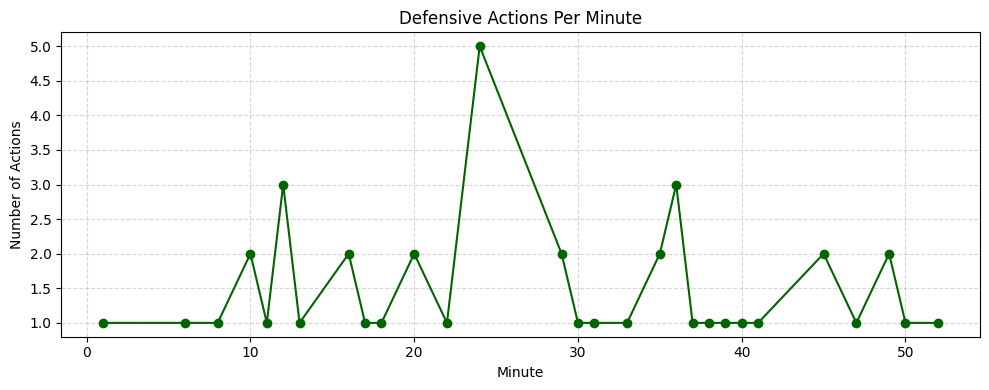

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from db_connection import get_connection

# CONFIG
your_team_id = '1oyb7oym5nwzny8vxf03szd2h' 
game_id = '6mvh0ixx6p3frjttob5szqcr8' # win 2-1
# game_id = '6aaebu7uj50ewu3irl3qmjg2c' # loss 2-4
# Defensive action types (as strings in your DB)
defensive_types = {
    '1': 'Tackle',
    '14': 'Duel',
    '17': 'Interception',
    '18': 'Clearance'
}

# Connect and load data
conn = get_connection()
query = f"""
SELECT action_type, seconds, team_id
FROM spadl_actions
WHERE game_id = '{game_id}' AND team_id = '{your_team_id}'
"""
df = pd.read_sql_query(query, conn)
conn.close()

# Filter only defensive actions
df = df[df['action_type'].isin(defensive_types.keys())]
df['action_label'] = df['action_type'].map(defensive_types)

# === 3️⃣ Histogram of Defensive Action Types ===
type_counts = df['action_label'].value_counts().reindex(defensive_types.values(), fill_value=0)

plt.figure(figsize=(8, 5))
type_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title("Count of Defensive Actions by Type")
plt.ylabel("Number of Actions")
plt.xlabel("Action Type")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 4️⃣ Line Graph: Defensive Actions Over Time (Minute bins) ===
df['minute'] = df['seconds'] // 60
actions_per_min = df.groupby('minute').size()

plt.figure(figsize=(10, 4))
actions_per_min.plot(kind='line', marker='o', color='darkgreen')
plt.title("Defensive Actions Per Minute")
plt.xlabel("Minute")
plt.ylabel("Number of Actions")
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
